### FLOOD PROBABILITY PREDICTION
* The goal of this notebook is to use computer vision on the static images to predict the probability of a location having a flood or not
* This probability will then be used as a feature for subsequent models and also used in normalizing the predictions to prevent overconfident predictions that hurt the loglosss score 

In [1]:
!pip install albumentations -q
!pip install timm -q
!pip install fastai 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 7.2 MB/s eta 0:00:000:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcugraph-cu12 24.12.0 requires pylibraft-cu12==24.12.*, but you have pylibraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 24.12.0 requires rmm-cu12==24.12.*, but you have 

In [5]:
import torch
import os
import random
import albumentations
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import gc 
import timm
from fastai.vision.all import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from fastai.metrics import accuracy
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations

from PIL import Image

le = LabelEncoder()
import warnings
warnings.filterwarnings('ignore')

In [6]:
def random_seed(seed_value, use_cuda): 
    np.random.seed(seed_value)
 #cpu vars
    torch.manual_seed(seed_value) 
# cpu  vars
    random.seed(seed_value)
 # Python 
    if use_cuda: 
        torch.cuda.manual_seed(seed_value) 
        torch.cuda.manual_seed_all(seed_value) 
# gpu vars
        torch.backends.cudnn.deterministic = True 
 #needed
        torch.backends.cudnn.benchmark = False 
#Remember to use num_workers=0 when creating the DataBunch.

random_seed(2024,True)

In [7]:
path = "/kaggle/input/flood-prediction/data/"
train = pd.read_csv(path + "Train.csv")
test = pd.read_csv(path + "Test.csv")
images = np.load(path + "composite_images.npz")
submission = pd.read_csv(path + "SampleSubmission.csv")

def get_location(value):
  return value.split("_")[0] + '_' + value.split("_")[1]

def get_event_id(value):
  return value.split("_")[3]
for df in [train, test]:
  df['location_id'] = df['event_id'].apply(lambda x: get_location(x))
  df['event'] = df['event_id'].apply(lambda x: get_event_id(x))

print(len(set(train['location_id'])), len(set(test['location_id'])))
print(len(set(train['location_id']).intersection(set(test['location_id']))))
print(len(images))
display(train.head(), test.head())

674 224
0
898


event_id  precipitation  label      location_id event
0  id_spictby0jfsb_X_0       0.000000      0  id_spictby0jfsb     0
1  id_spictby0jfsb_X_1       0.095438      0  id_spictby0jfsb     1
2  id_spictby0jfsb_X_2       1.949560      0  id_spictby0jfsb     2
3  id_spictby0jfsb_X_3       3.232160      0  id_spictby0jfsb     3
4  id_spictby0jfsb_X_4       0.000000      0  id_spictby0jfsb     4

event_id  precipitation      location_id event
0  id_j7b6sokflo4k_X_0        0.00000  id_j7b6sokflo4k     0
1  id_j7b6sokflo4k_X_1        3.01864  id_j7b6sokflo4k     1
2  id_j7b6sokflo4k_X_2        0.00000  id_j7b6sokflo4k     2
3  id_j7b6sokflo4k_X_3       16.61520  id_j7b6sokflo4k     3
4  id_j7b6sokflo4k_X_4        2.56706  id_j7b6sokflo4k     4

In [12]:
BAND_NAMES = ('B2', 'B3', 'B4', 'B8', 'B11', 'SLOPE')
H,W, NUM_CHANNELS = IMG_DIM = (128, 128, len(BAND_NAMES))
print(IMG_DIM)

(128, 128, 6)


In [8]:
train_grouped = pd.DataFrame(train.groupby('location_id')['label'].agg('max')).reset_index()
test_grouped = pd.DataFrame(test.groupby('location_id')['event_id'].count()).reset_index()
test_grouped.columns = ['location_id', 'event_id_counts']
display(train_grouped.head(), test_grouped.head())

location_id  label
0  id_05v6zjuaf300      1
1  id_06zma02zeea7      0
2  id_08w2po0cz63y      0
3  id_092vetuky9ku      0
4  id_0987b1h04r48      1

location_id  event_id_counts
0  id_066zz28m11mr              730
1  id_073l04ir88sn              730
2  id_0ajr0br1b046              730
3  id_0mdchsqsdw17              730
4  id_0nu2nus290am              730

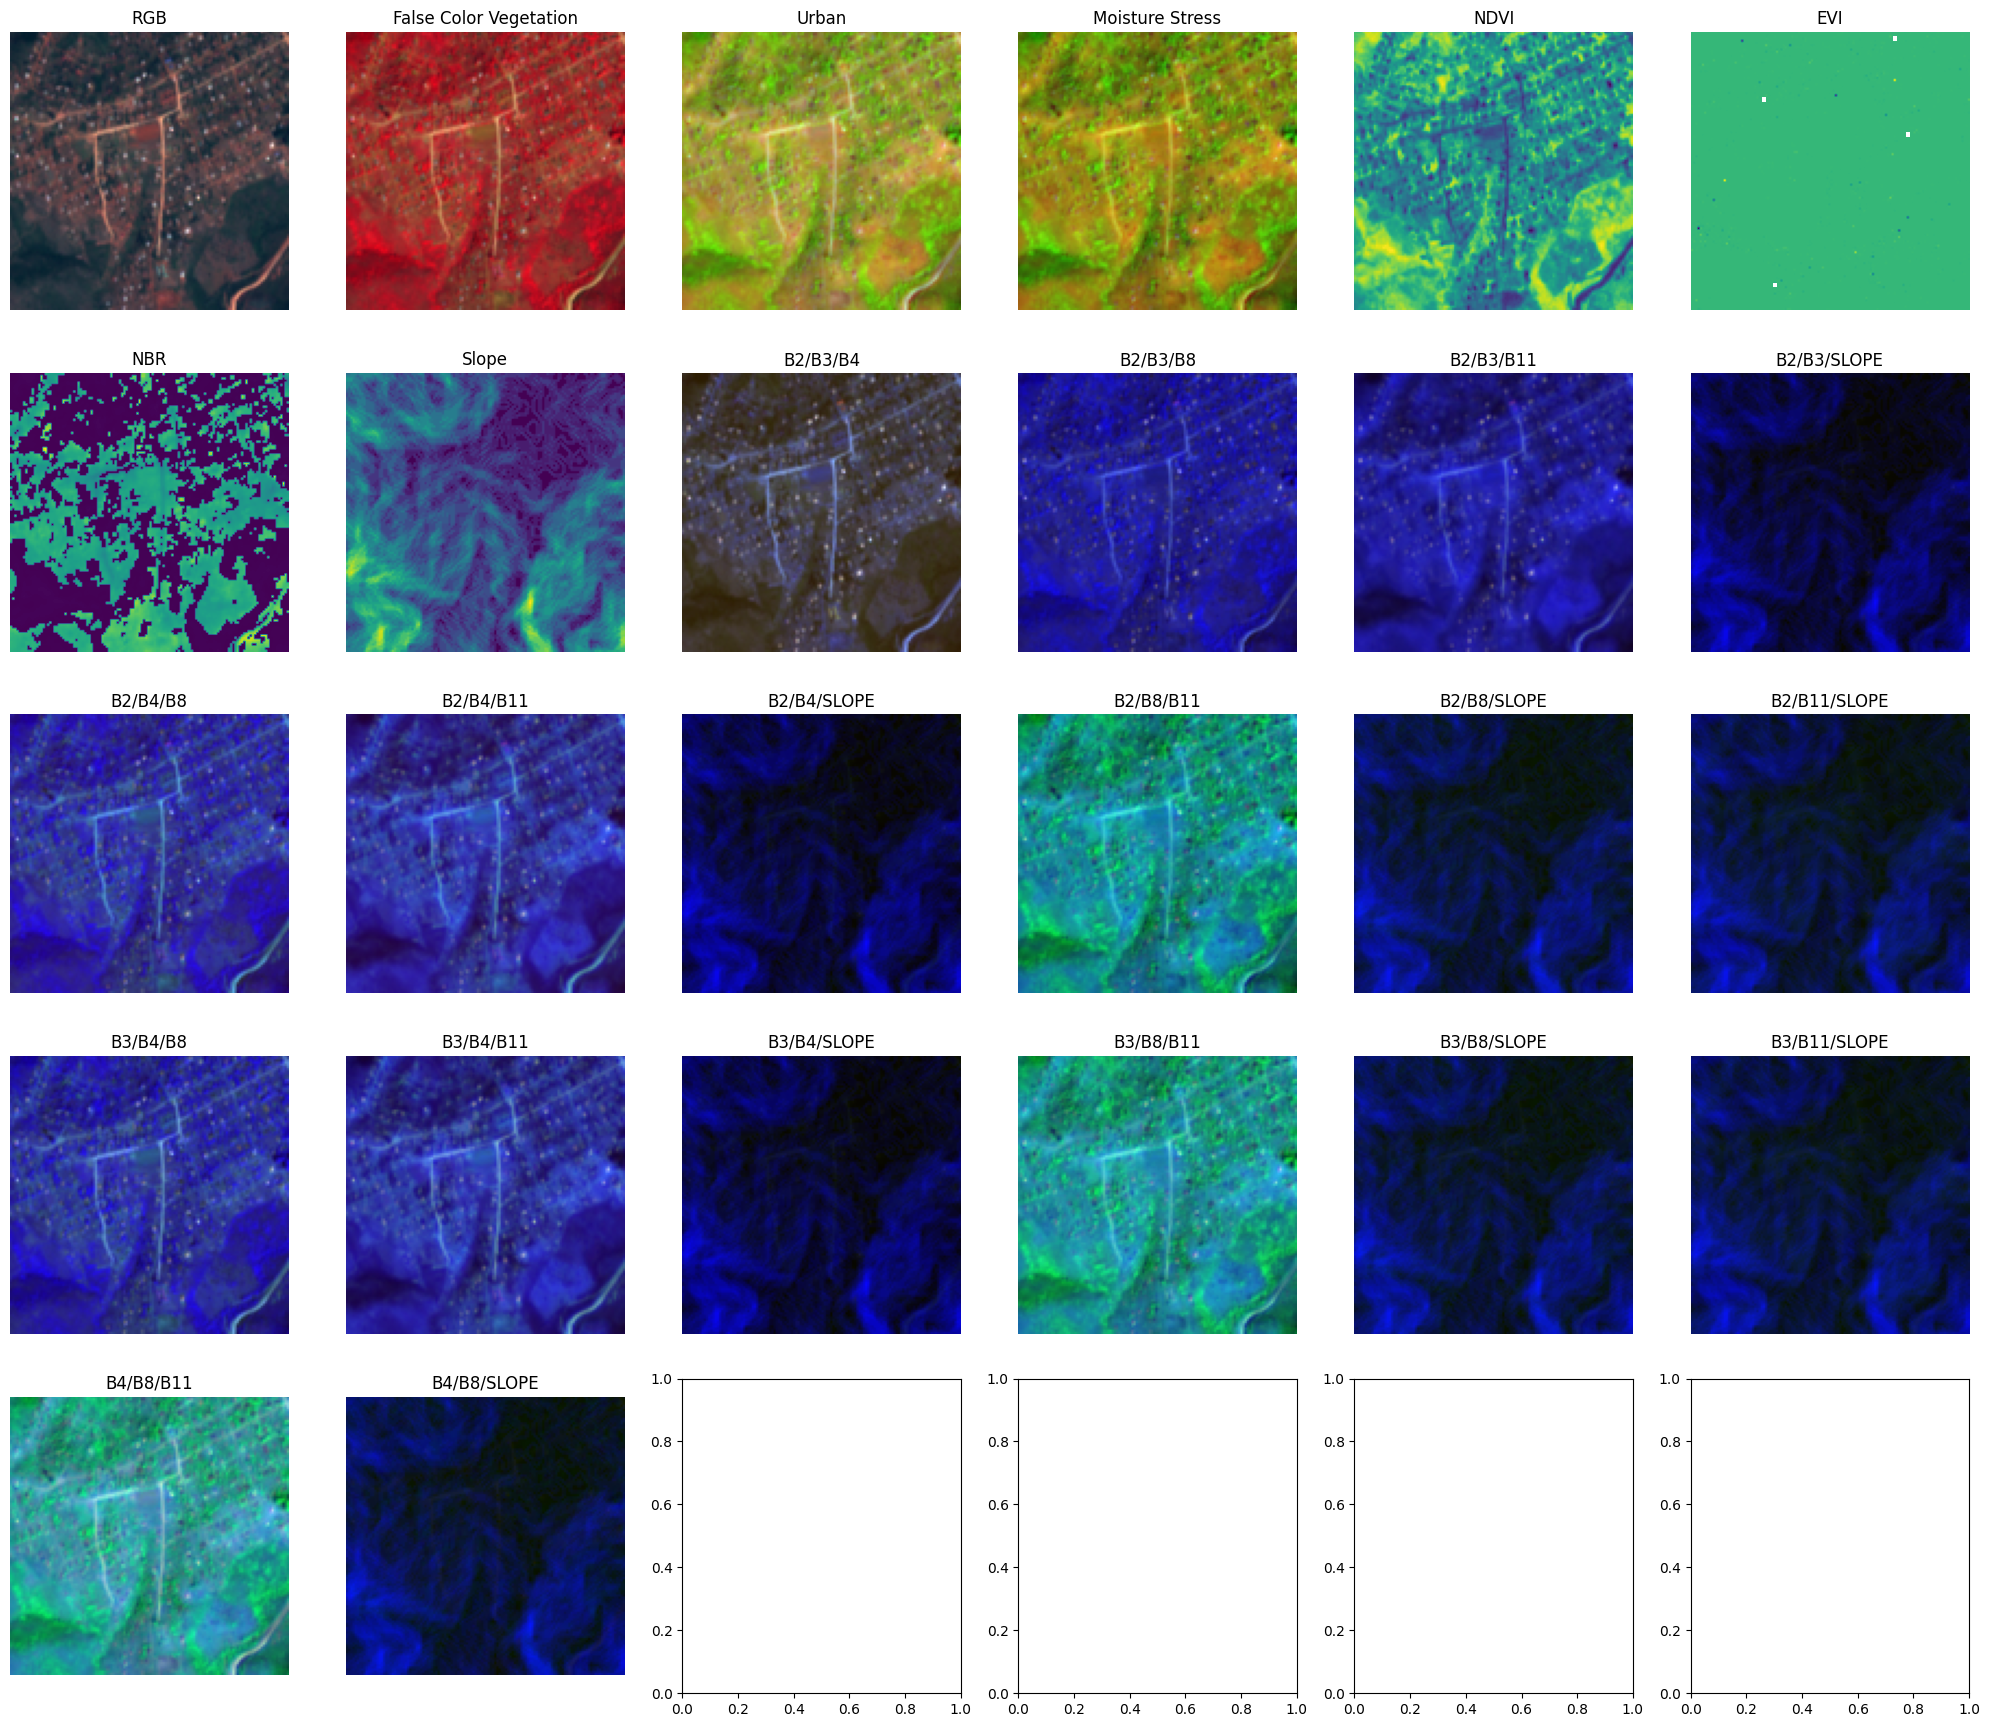

Potential 3-band combinations for CNN:
('B2', 'B3', 'B4')
('B2', 'B3', 'B8')
('B2', 'B3', 'B11')
('B2', 'B3', 'SLOPE')
('B2', 'B4', 'B8')
('B2', 'B4', 'B11')
('B2', 'B4', 'SLOPE')
('B2', 'B8', 'B11')
('B2', 'B8', 'SLOPE')
('B2', 'B11', 'SLOPE')
('B3', 'B4', 'B8')
('B3', 'B4', 'B11')
('B3', 'B4', 'SLOPE')
('B3', 'B8', 'B11')
('B3', 'B8', 'SLOPE')
('B3', 'B11', 'SLOPE')
('B4', 'B8', 'B11')
('B4', 'B8', 'SLOPE')
('B4', 'B11', 'SLOPE')
('B8', 'B11', 'SLOPE')


In [13]:
event_id = 'id_rhg5w8vmv3ny'

import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations

def calculate_ndvi(red_band, nir_band):
    """Calculate Normalized Difference Vegetation Index (NDVI)"""
    return (nir_band - red_band) / (nir_band + red_band)

def calculate_evi(blue, red, nir):
    """Calculate Enhanced Vegetation Index (EVI)"""
    G = 2.5
    C1 = 6
    C2 = 7.5
    L = 1
    return G * ((nir - red) / (nir + C1 * red - C2 * blue + L))

def calculate_nbr(nir, swir):
    """Normalized Burn Ratio (NBR)"""
    return (nir - swir) / (nir + swir)

def create_comprehensive_band_visualization(images, event_id, band_names):
    # Map band indices for easy access
    band_indices = {name: band_names.index(name) for name in band_names}

    # Extract all bands
    bands = {name: images[event_id][..., idx] for name, idx in band_indices.items()}

    # Create various composite and index images
    composites = {
        'RGB': np.stack([bands['B4'], bands['B3'], bands['B2']], axis=-1),
        'False Color Vegetation': np.stack([bands['B8'], bands['B4'], bands['B3']], axis=-1),
        'Urban': np.stack([bands['B11'], bands['B8'], bands['B4']], axis=-1),
        'Moisture Stress': np.stack([bands['B11'], bands['B8'], bands['B2']], axis=-1)
    }

    # Normalize composites
    for name, composite in composites.items():
        composites[name] = (composite - composite.min()) / (composite.max() - composite.min())

    # Calculate indices
    indices = {
        'NDVI': calculate_ndvi(bands['B4'], bands['B8']),
        'EVI': calculate_evi(bands['B2'], bands['B4'], bands['B8']),
        'NBR': calculate_nbr(bands['B8'], bands['B11']),
        'Slope': bands['SLOPE']
    }

    # Prepare all potential 3-band combinations for CNN exploration
    band_list = ['B2', 'B3', 'B4', 'B8', 'B11', 'SLOPE']
    potential_combinations = list(combinations(band_list, 3))

    # Create visualization
    num_images = len(composites) + len(indices) + len(potential_combinations)
    rows = (num_images + 5) // 6  # Ensure we have enough rows

    _, axes = plt.subplots(
        nrows=rows,
        ncols=6,
        figsize=(20, rows * 3.5),
        facecolor='white'
    )
    axes = axes.flatten()

    # Plot composites
    for i, (name, composite) in enumerate(composites.items()):
        axes[i].imshow(composite)
        axes[i].set_title(name)
        axes[i].axis('off')

    # Plot indices
    for i, (name, index) in enumerate(indices.items(), start=len(composites)):
        axes[i].imshow(index, cmap='viridis')
        axes[i].set_title(name)
        axes[i].axis('off')

    # Plot potential 3-band combinations
    combo_start = len(composites) + len(indices)
    for i, combo in enumerate(potential_combinations[:6-combo_start], start=combo_start):
        three_band_combo = np.stack([bands[combo[0]], bands[combo[1]], bands[combo[2]]], axis=-1)
        three_band_combo = (three_band_combo - three_band_combo.min()) / (three_band_combo.max() - three_band_combo.min())
        axes[i].imshow(three_band_combo)
        axes[i].set_title(f'{combo[0]}/{combo[1]}/{combo[2]}')
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

    # Return potential combinations for CNN
    return potential_combinations

# Generate visualizations and get potential combinations
potential_cnn_combinations = create_comprehensive_band_visualization(images, event_id, BAND_NAMES)

# Print out the potential combinations
print("Potential 3-band combinations for CNN:")
for combo in potential_cnn_combinations:
    print(combo)


In [14]:
train_grouped = pd.DataFrame(train.groupby('location_id')['label'].agg('max')).reset_index()
test_grouped = pd.DataFrame(test.groupby('location_id')['event_id'].count()).reset_index()
test_grouped.columns = ['location_id', 'event_id_counts']
display(train_grouped.head(), test_grouped.head())

location_id  label
0  id_05v6zjuaf300      1
1  id_06zma02zeea7      0
2  id_08w2po0cz63y      0
3  id_092vetuky9ku      0
4  id_0987b1h04r48      1

location_id  event_id_counts
0  id_066zz28m11mr              730
1  id_073l04ir88sn              730
2  id_0ajr0br1b046              730
3  id_0mdchsqsdw17              730
4  id_0nu2nus290am              730

In [15]:
train_grouped['label'].value_counts()

label
0    356
1    318
Name: count, dtype: int64

In [16]:
import os
import numpy as np
from PIL import Image
from itertools import combinations
from tqdm import tqdm

# Create directories for each valid combination
def create_directories(parent_dir, combinations):
    for combo in combinations:
        combo_folder = os.path.join(parent_dir, combo)
        # Check if the directory exists, and create it if it doesn't
        if not os.path.exists(combo_folder):
            os.makedirs(combo_folder)

# Function to check if a given combination is valid (i.e., 3 bands)
def is_valid_combination(bands, combination):
    return all(band in bands for band in combination)

# Save valid 3-band combinations (composite images)
def save_valid_3band_combinations(images, train_df, band_names, parent_dir, image_format='png'):
    # Define possible band combinations (3-band)
    composites = {
        # 'RGB': ['B4', 'B3', 'B2'],
        # 'False Color Vegetation': ['B8', 'B4', 'B3'],
        # 'Urban': ['B11', 'B8', 'B4'],
        'Moisture Stress': ['B11', 'B8', 'B2'],
        # You can add more combinations as needed
    }

    # Additional 3-band combinations from the available bands
    # band_list = ['B2', 'B3', 'B4', 'B8', 'B11', 'SLOPE']
    # additional_combinations = list(combinations(band_list, 3))

    # # Add additional combinations to the composites dictionary
    # for comb in additional_combinations:
    #     comb_name = '_'.join(comb)
    #     composites[comb_name] = list(comb)

    # Create directories for the combinations
    create_directories(parent_dir, composites.keys())
    print(composites.keys())

    # Iterate over the training dataset
    for idx, row in tqdm(train_df.iterrows(), total=len(train_df), desc="Saving Images", unit="image"):
        location_id = row['location_id']

        # Extract bands for the current location
        band_indices = {name: band_names.index(name) for name in band_names}
        bands = {name: images[location_id][..., idx] for name, idx in band_indices.items()}

        # Iterate through the composites and save valid 3-channel images
        for composite_name, band_keys in composites.items():
            if is_valid_combination(bands, band_keys):
                # Stack the bands
                composite_image = np.stack([bands[band] for band in band_keys], axis=-1)

                # Ensure the image has exactly 3 channels
                if composite_image.shape[-1] == 3:
                    # Normalize the image to the range [0, 255]
                    composite_image = (composite_image - composite_image.min()) / (composite_image.max() - composite_image.min()) * 255
                    composite_image = composite_image.astype(np.uint8)

                    # Resize the image to 384x384
                    pil_img = Image.fromarray(composite_image)
                    pil_img = pil_img.resize((384, 384), Image.Resampling.LANCZOS)

                    # Construct the path to save the image
                    save_dir = os.path.join(parent_dir, composite_name)
                    save_path = os.path.join(save_dir, f'{location_id}.{image_format}')

                    # Check if the image already exists before saving it
                    if not os.path.exists(save_path):
                        # Save the image
                        pil_img.save(save_path)

    print(f"Images have been saved successfully to {parent_dir}")

# Example usage
save_valid_3band_combinations(images, train_grouped, BAND_NAMES, '/kaggle/working/', image_format='png')

dict_keys(['Moisture Stress'])


Saving Images: 100%|██████████| 674/674 [00:53<00:00, 12.70image/s]

Images have been saved successfully to /kaggle/working/


In [17]:
save_valid_3band_combinations(images, test_grouped, BAND_NAMES, '/kaggle/working/', image_format='png')


dict_keys(['Moisture Stress'])


Saving Images: 100%|██████████| 224/224 [00:17<00:00, 13.01image/s]

Images have been saved successfully to /kaggle/working/


In [18]:
len(os.listdir('/kaggle/working/Moisture Stress'))

898

### COnfig

In [19]:
timm.list_models('eva*')

['eva02_base_patch14_224',
 'eva02_base_patch14_448',
 'eva02_base_patch16_clip_224',
 'eva02_enormous_patch14_clip_224',
 'eva02_large_patch14_224',
 'eva02_large_patch14_448',
 'eva02_large_patch14_clip_224',
 'eva02_large_patch14_clip_336',
 'eva02_small_patch14_224',
 'eva02_small_patch14_336',
 'eva02_tiny_patch14_224',
 'eva02_tiny_patch14_336',
 'eva_giant_patch14_224',
 'eva_giant_patch14_336',
 'eva_giant_patch14_560',
 'eva_giant_patch14_clip_224',
 'eva_large_patch14_196',
 'eva_large_patch14_336']

In [22]:
class Config:
    n_splits = 10
    seed = 2024
    image_path = "/kaggle/working/Moisture Stress/"
    image_size = 224
    img_extension = '.png'
    model_name = "eva02_tiny_patch14_224"
    batch_size = 32
    epochs = 15
    tta = 5
    num_classes = 2

len(os.listdir(Config.image_path)), train_grouped.shape

(898, (674, 2))

In [23]:
skf = StratifiedKFold(n_splits = Config.n_splits, shuffle=True, random_state = Config.seed)
train_grouped['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(train_grouped, train_grouped['label'])):
    train_grouped.loc[val_idx, "fold"] = fold

train_grouped['fold'].value_counts()

fold
0    68
2    68
3    68
1    68
9    67
4    67
8    67
7    67
6    67
5    67
Name: count, dtype: int64

In [24]:
train_grouped.label.value_counts()

label
0    356
1    318
Name: count, dtype: int64

In [25]:

train_grouped['image_path'] = Config.image_path + train_grouped['location_id'] + Config.img_extension
test_grouped['image_path'] = Config.image_path + test_grouped['location_id'] + Config.img_extension
display(train_grouped.head(), test_grouped.head())

location_id  label  fold  \
0  id_05v6zjuaf300      1     9   
1  id_06zma02zeea7      0     0   
2  id_08w2po0cz63y      0     4   
3  id_092vetuky9ku      0     2   
4  id_0987b1h04r48      1     8   

                                            image_path  
0  /kaggle/working/Moisture Stress/id_05v6zjuaf300.png  
1  /kaggle/working/Moisture Stress/id_06zma02zeea7.png  
2  /kaggle/working/Moisture Stress/id_08w2po0cz63y.png  
3  /kaggle/working/Moisture Stress/id_092vetuky9ku.png  
4  /kaggle/working/Moisture Stress/id_0987b1h04r48.png

location_id  event_id_counts  \
0  id_066zz28m11mr              730   
1  id_073l04ir88sn              730   
2  id_0ajr0br1b046              730   
3  id_0mdchsqsdw17              730   
4  id_0nu2nus290am              730   

                                            image_path  
0  /kaggle/working/Moisture Stress/id_066zz28m11mr.png  
1  /kaggle/working/Moisture Stress/id_073l04ir88sn.png  
2  /kaggle/working/Moisture Stress/id_0ajr0br1b046.png  
3  /kaggle/working/Moisture Stress/id_0mdchsqsdw17.png  
4  /kaggle/working/Moisture Stress/id_0nu2nus290am.png

### Albumentation Augmentations

In [26]:
class AlbumentationsTransform (RandTransform):
    split_idx,order=None,2
    def __init__(self, train_aug, valid_aug): store_attr()
    
    def before_call(self, b, split_idx):
        self.idx = split_idx
    
    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
        return PILImage.create(aug_img)

In [27]:
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(Config.image_size, Config.image_size), #Extra tip, use size that's suitable for the efficentNetwork you are using.

            albumentations.HorizontalFlip(p=0.5),
            albumentations.VerticalFlip(p=0.5),
            
            albumentations.RandomBrightnessContrast(
                brightness_limit=(-0.1,0.1), 
                contrast_limit=(-0.1, 0.1), 
                p=0.5
            ),
            albumentations.HueSaturationValue(
                hue_shift_limit=0.2, 
                sat_shift_limit=0.2, 
                val_shift_limit=0.2, 
                p=0.5
            ),
              
            ], p=1.)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(Config.image_size, Config.image_size),
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

### Data Loaders

In [28]:
# to learn more about datablocks in fast you have to visit fastai.docs
def get_datablock(Train, fold=0, bs=32):
    return DataBlock(blocks=(ImageBlock,CategoryBlock),
                get_x=ColReader("image_path"),
                get_y=ColReader(['label']),
                splitter=IndexSplitter(Train[Train.fold == fold].index),
                item_tfms = item_tfms,
                batch_tfms = batch_tfms).dataloaders(Train, bs=bs)

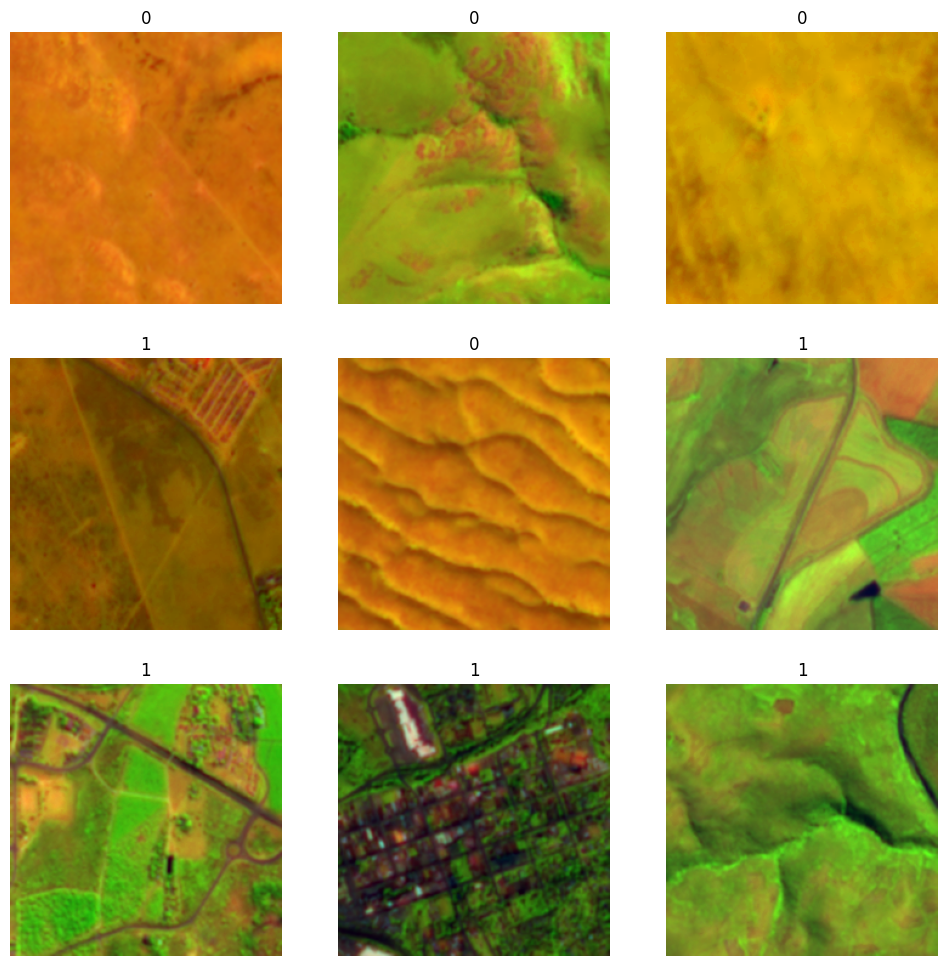

In [29]:
get_datablock(train_grouped).show_batch(figsize=(12,12))

### Model + Metrics

In [30]:
roc = RocAucBinary()
metrics = [roc, accuracy]


In [ ]:
# Initialize OOF predictions array with zeros
oof_preds = np.zeros((len(train_grouped), Config.num_classes))
all_preds = []
for i in range(Config.n_splits):
    # Get data for the current fold
    print(f"=======================================TRAINING FOLD: {i+1}================================================")
    dls = get_datablock(train_grouped, i, Config.batch_size)
    learn = vision_learner(
        dls, Config.model_name, 
        loss_func=CrossEntropyLossFlat(), 
        metrics=metrics, 
        cbs=[SaveModelCallback()]
    )
    
    # Learning rate finder and fine-tune
    _valley, _slide = learn.lr_find(suggest_funcs=(valley, slide))
    learn.fine_tune(Config.epochs, _valley)
    
    # Generate OOF predictions for the validation set
    val_idx = dls.valid.items.index
    val_dl = learn.dls.valid
    val_preds, _ = learn.tta(dl=val_dl, n=Config.tta)
    
    # Save OOF predictions for the current fold
    oof_preds[val_idx] = val_preds.numpy()

    # Generate test predictions
    test_dl = learn.dls.test_dl(test_grouped)
    preds, _ = learn.tta(dl=test_dl, n=Config.tta)
    all_preds.append(preds)
    
    # Clean up to free memory
    del learn
    torch.cuda.empty_cache()
    gc.collect()

# Add OOF predictions as a new column to the training dataset
train_grouped['oof_preds'] = list(oof_preds)
display(train_grouped.head())


# Display the updated DataFrame
display(train_grouped.head())


=======================================TRAINING FOLD: 1================================================


model.safetensors:   0%|          | 0.00/22.0M [00:00<?, ?B/s]

Better model found at epoch 0 with valid_loss value: 0.45342153310775757.


Better model found at epoch 0 with valid_loss value: 0.5277954339981079.
Better model found at epoch 1 with valid_loss value: 0.5199694037437439.
Better model found at epoch 2 with valid_loss value: 0.49724942445755005.
Better model found at epoch 5 with valid_loss value: 0.42839255928993225.
Better model found at epoch 8 with valid_loss value: 0.4275447130203247.
Better model found at epoch 10 with valid_loss value: 0.39655235409736633.


=======================================TRAINING FOLD: 2================================================


Better model found at epoch 0 with valid_loss value: 0.46518340706825256.


Better model found at epoch 0 with valid_loss value: 0.3850145637989044.
Better model found at epoch 1 with valid_loss value: 0.3609713912010193.


=======================================TRAINING FOLD: 3================================================


Better model found at epoch 0 with valid_loss value: 0.3414393365383148.


Better model found at epoch 0 with valid_loss value: 0.3242131471633911.
Better model found at epoch 1 with valid_loss value: 0.30768898129463196.
Better model found at epoch 2 with valid_loss value: 0.2804758548736572.
Better model found at epoch 3 with valid_loss value: 0.28026339411735535.
Better model found at epoch 4 with valid_loss value: 0.27781420946121216.
Better model found at epoch 5 with valid_loss value: 0.2456265091896057.
Better model found at epoch 8 with valid_loss value: 0.22878722846508026.
Better model found at epoch 9 with valid_loss value: 0.22284288704395294.


=======================================TRAINING FOLD: 4================================================


Better model found at epoch 0 with valid_loss value: 0.2929742932319641.


Better model found at epoch 0 with valid_loss value: 0.2759854793548584.
Better model found at epoch 1 with valid_loss value: 0.24267667531967163.
Better model found at epoch 2 with valid_loss value: 0.20274923741817474.
Better model found at epoch 3 with valid_loss value: 0.20053435862064362.
Better model found at epoch 4 with valid_loss value: 0.16451188921928406.


=======================================TRAINING FOLD: 5================================================


Better model found at epoch 0 with valid_loss value: 0.42758163809776306.


Better model found at epoch 0 with valid_loss value: 0.34444960951805115.
Better model found at epoch 1 with valid_loss value: 0.3017232120037079.
Better model found at epoch 2 with valid_loss value: 0.2951873242855072.


=======================================TRAINING FOLD: 6================================================


Better model found at epoch 0 with valid_loss value: 0.34569883346557617.


Better model found at epoch 0 with valid_loss value: 0.3006100058555603.


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

# Extract the correct probability for each row in train_grouped
train_grouped['flood_probability'] = train_grouped['oof_preds'].apply(
    lambda preds: preds[1]  # Assuming `preds[1]` is the probability for the positive class (label = 1)
    if len(preds) > 1 else preds[0]  # Safeguard if preds contains only one probability
)

# Calculate the ROC AUC score
roc_score = roc_auc_score(train_grouped['label'], train_grouped['flood_probability'])
print("ROC AUC Score:", roc_score)

# Get the predicted class by choosing the class with the highest probability
train_grouped['predicted_class'] = train_grouped['oof_preds'].apply(
    lambda preds: 1 if preds[1] > preds[0] else 0  # If probability for class 1 is higher, predict class 1
)

# Calculate the accuracy score
accuracy = accuracy_score(train_grouped['label'], train_grouped['predicted_class'])
print("Accuracy Score:", accuracy)

# Convert oof_preds (list of probabilities) into a NumPy array for log loss calculation
oof_probs = np.stack(train_grouped['oof_preds'].values)

# Calculate the log loss
logloss = log_loss(train_grouped['label'], oof_probs)
print("Log Loss:", logloss)


In [ ]:
train_grouped.head()

In [ ]:
train_grouped.to_csv("train_with_cv_results.csv", index=False)

### INFERENCE

In [ ]:
# Convert the list of all_preds to a single NumPy array
# Shape of all_preds: (n_splits, num_test_samples, num_classes)
all_preds_array = np.array([pred.numpy() for pred in all_preds])

# Compute the mean predictions across folds (axis=0)
mean_test_preds = all_preds_array.mean(axis=0)

# Extract the probability of the predicted class (highest probability)
# For ROC AUC, we need the probabilities for the positive class (class 1)
# Assuming the second column is for the positive class (class 1), adjust as needed
test_grouped['flood_probability'] = mean_test_preds[:, 1]  # Class 1 probability

# Optionally, extract the predicted class (class with the highest probability)
test_grouped['predicted_class'] = mean_test_preds.argmax(axis=1)

# Display the updated test DataFrame
display(test_grouped.head())


In [ ]:
test_grouped.to_csv("test_with_cv_results.csv", index=False)